In [24]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.5.
The scikit-learn version is 0.22.2.


In [2]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from scipy.stats import hmean



filename = 'capture20110810.binetflow'
try:
    # try to load the file from a local directory
    data = pd.read_csv(filename)
    pass
except:
    # fetch it from the url
    data = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/{}'.format(filename))
    data.to_csv(filename)
    pass

In [3]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established


In [4]:
data['Target'] = data['Label'].str.startswith('flow=From-Botnet').astype(int)

In [5]:
targetno = data[data['Target']==0]

In [6]:
targetyes = data[data['Target']==1]

In [7]:
print('Percent Minority %f' % ((sum(data['Target'])/len(data['Target']))*100))

Percent Minority 1.450134


In [8]:
targetno.shape

(2783675, 16)

# Smote takes too long with categoricals, so I manaully resampled due to computing power restrictions

In [9]:
drop_indices = np.random.choice(targetno.index, 2740000, replace=False)
targetno_new = targetno.drop(drop_indices)

In [10]:
net_flows_new = targetno_new.append(targetyes)

In [11]:
print('Percent Minority %f' % ((sum(net_flows_new['Target'])/len(net_flows_new['Target']))*100))

Percent Minority 48.396663


In [12]:
net_flows = net_flows_new.dropna()
X = net_flows.iloc[:,0:14]
y = net_flows['Target']

In [13]:
print('Percent Minority %f' % ((sum(y)/len(y))*100))

Percent Minority 40.868933


# Actually fitting smote

In [14]:
categorics = ['StartTime', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State']

In [15]:
cat_index = [net_flows.columns.get_loc(c) for c in categorics if c in X]

In [16]:
sm = SMOTENC(random_state = 42, categorical_features=[0, 2, 3, 4, 5, 6, 7, 8])

In [17]:
X_res, y_res = sm.fit_resample(X, y)

In [18]:
print('Percent Minority %f' % ((sum(y_res)/len(y_res))*100))

Percent Minority 50.000000


# AAAANNNNDDD we're at a balanced dataset now

In [28]:
X.shape

(68820, 14)

In [19]:
X_res.shape

(81388, 14)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression
model score: 0.638

Confusion matrix, without normalization
[[2673 5476]
 [ 420 7709]]
Normalized confusion matrix
[[0.32801571 0.67198429]
 [0.05166687 0.94833313]]


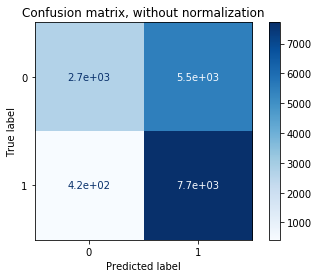

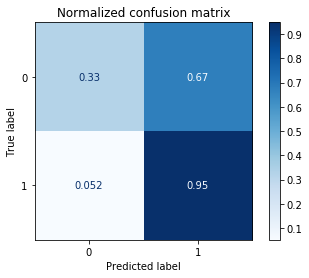

              precision    recall  f1-score   support

           0       0.86      0.33      0.48      8149
           1       0.58      0.95      0.72      8129

    accuracy                           0.64     16278
   macro avg       0.72      0.64      0.60     16278
weighted avg       0.72      0.64      0.60     16278

average precision score: 0.493
roc_auc_score: 0.546
precision-recall AUC: 0.493

RandomForestClassifier
model score: 0.887

Confusion matrix, without normalization
[[7721  428]
 [1405 6724]]
Normalized confusion matrix
[[0.94747822 0.05252178]
 [0.17283799 0.82716201]]


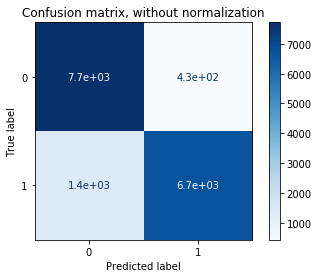

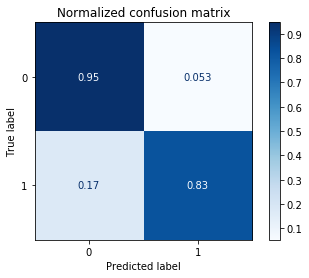

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      8149
           1       0.94      0.83      0.88      8129

    accuracy                           0.89     16278
   macro avg       0.89      0.89      0.89     16278
weighted avg       0.89      0.89      0.89     16278

average precision score: 0.967
roc_auc_score: 0.968
precision-recall AUC: 0.967

GradientBoostingClassifier
model score: 0.890

Confusion matrix, without normalization
[[7354  795]
 [1003 7126]]
Normalized confusion matrix
[[0.90244202 0.09755798]
 [0.12338541 0.87661459]]


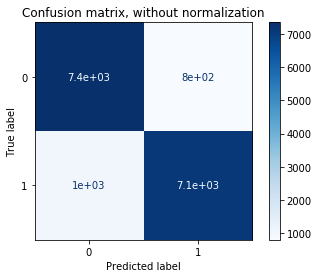

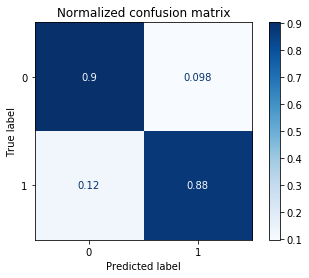

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8149
           1       0.90      0.88      0.89      8129

    accuracy                           0.89     16278
   macro avg       0.89      0.89      0.89     16278
weighted avg       0.89      0.89      0.89     16278

average precision score: 0.952
roc_auc_score: 0.956
precision-recall AUC: 0.953



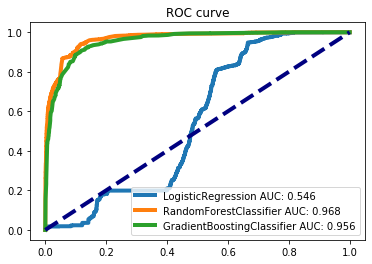

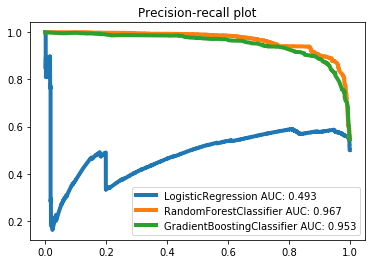

In [20]:
numeric_features = ['Dur', 'TotPkts', 'TotBytes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_features = ['Proto','Dir','State']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', None)])

roc_things = []
precision_recall_things = []

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(min_samples_leaf = 10),
    GradientBoostingClassifier()
]

for classifier in classifiers:
    clf.set_params(clf=classifier).fit(X_train, y_train)
    classifier_name = classifier.__class__.__name__
    print(str(classifier_name))
    print("model score: %.3f\n" % clf.score(X_test, y_test))

    
    y_score = clf.predict_proba(X_test)[:,1]
    
    y_pred = clf.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_things.append((fpr, tpr, '{} AUC: {:.3f}'.format(classifier_name, roc_auc)))
    
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
    
    print(classification_report(y_test, y_pred))
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    precision_recall_things.append((recall, precision, thresholds, '{} AUC: {:.3f}'.format(classifier_name, pr_auc)))
    
    
    print('average precision score: {:.3f}'.format(average_precision_score(y_test, y_score)))
    print('roc_auc_score: {:.3f}'.format(roc_auc))
    print('precision-recall AUC: {:.3f}'.format(pr_auc))
    print()
    
    with open('{}.pkl'.format(str(classifier_name)), 'wb') as f:
        pkl.dump(clf, f)

roc_plt = plt.figure()
lw = 4
for roc_thing in roc_things:
    fpr, tpr, label = roc_thing
    plt.plot(fpr, tpr, lw=lw, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.legend()
plt.title('ROC curve')

pr_plt = plt.figure()
for pr_thing in precision_recall_things:
    recall, precision, _, label = pr_thing
    plt.plot(recall, precision, lw=lw, label=label)
#ratio = y_test[y_test].shape[0] / y_test.shape[0]
#plt.hlines(y=ratio, xmin=0, xmax=1, color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.title('Precision-recall plot')
plt.legend()   

# Threshold Stuffs

In [21]:
print(thresholds)

[0.02965799 0.02984897 0.03057726 0.03097229 0.03299531 0.03390803
 0.03440783 0.03492461 0.03517857 0.03563608 0.03581595 0.03582538
 0.03598095 0.03599154 0.03943491 0.03988121 0.0404493  0.04045635
 0.04166786 0.042026   0.04416702 0.04531341 0.04579514 0.04632329
 0.047138   0.0473118  0.04732453 0.04911697 0.04926346 0.04930595
 0.04975449 0.0510767  0.05145336 0.05203717 0.05249859 0.05256322
 0.05275803 0.0527986  0.05311228 0.05412132 0.05417404 0.05429069
 0.05488813 0.05505536 0.05506956 0.05518984 0.05576408 0.05623045
 0.05657929 0.05672718 0.05681486 0.05702947 0.05720118 0.0575788
 0.05780413 0.05888786 0.05907978 0.05916138 0.05969192 0.06004252
 0.06033386 0.06116217 0.06116584 0.06127797 0.06131428 0.06226358
 0.06343137 0.06368006 0.06443472 0.06506423 0.06544649 0.06583726
 0.06692913 0.06716471 0.06720212 0.06776414 0.06789235 0.06830453
 0.06845281 0.06882838 0.06915494 0.06919071 0.06947938 0.07124672
 0.07143499 0.07167077 0.07169458 0.07171275 0.0718743  0.07188

In [22]:
precision, recall, thresholds_2 = precision_recall_curve(y_test, y_score)

a = np.column_stack((recall,precision))

a = ma.masked_less_equal(a,0)
a = ma.mask_rows(a)
f1 = hmean(a,axis=1)

In [23]:
threshold_maximizing_F1 = thresholds[np.argmax(f1)]
print('f1 optimizing threshold: {}'.format(threshold_maximizing_F1))

f1 optimizing threshold: 0.34902243946125083
